# Flagrant Foul Impact on Point Differential (2023-24 Season)

Linear regression with continuous outcome: Does committing a flagrant foul worsen point differential?

Model: point_differential ~ committed_flagrant_foul

In [ ]:
# Load raw game data
csv_file = Path('nba_flagrant_fouls.csv')

if not csv_file.exists():
    print(f"Error: {csv_file} not found")
else:
    games_with_data = pd.read_csv(csv_file)
    print(f"Loaded {len(games_with_data)} games from CSV")
    print(f"Columns: {games_with_data.columns.tolist()}")

## 1. Load and Prepare Data

In [2]:
# Load raw game data
csv_file = Path('flagrant_fouls_2023_24.csv')

if not csv_file.exists():
    print(f"Error: {csv_file} not found")
else:
    games_with_data = pd.read_csv(csv_file)
    print(f"Loaded {len(games_with_data)} games from CSV")
    print(f"Columns: {games_with_data.columns.tolist()}")

Loaded 600 games from CSV
Columns: ['game_id', 'home_team', 'away_team', 'home_flagrants', 'away_flagrants', 'home_score', 'away_score']


In [3]:
# Create long-format dataset: one row per team per game
home_data = games_with_data[['game_id', 'home_team', 'home_flagrants', 'home_score', 'away_score']].copy()
home_data.columns = ['game_id', 'team_id', 'committed_flagrant', 'team_score', 'opp_score']
home_data['location'] = 'home'

away_data = games_with_data[['game_id', 'away_team', 'away_flagrants', 'away_score', 'home_score']].copy()
away_data.columns = ['game_id', 'team_id', 'committed_flagrant', 'team_score', 'opp_score']
away_data['location'] = 'away'

# Combine home and away
df = pd.concat([home_data, away_data], ignore_index=True)

# Create continuous outcome: point differential
df['point_differential'] = df['team_score'] - df['opp_score']

# Convert flagrant count to binary (committed at least one flagrant foul)
df['committed_flagrant'] = (df['committed_flagrant'] > 0).astype(int)

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))


Dataset shape: (1200, 7)

First few rows:
    game_id     team_id  committed_flagrant  team_score  opp_score location  \
0  42300405  1610612738                   0         106         88     home   
1  42300404  1610612742                   0         122         84     home   
2  42300403  1610612742                   0          99        106     home   
3  42300402  1610612738                   0         105         98     home   
4  42300401  1610612738                   0         107         89     home   
5  42300315  1610612750                   1         103        124     home   
6  42300314  1610612742                   0         100        105     home   
7  42300304  1610612754                   0         102        105     home   
8  42300313  1610612742                   0         116        107     home   
9  42300303  1610612754                   0         111        114     home   

   point_differential  
0                  18  
1                  38  
2              

## 2. Descriptive Statistics

In [4]:
# Summary statistics by flagrant status
print("\nPoint Differential by Flagrant Foul Status:")
print("="*70)

summary_stats = df.groupby('committed_flagrant')['point_differential'].agg([
    ('n', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('median', 'median')
])

summary_stats.index = ['No Flagrant', 'Committed Flagrant']
print(summary_stats)

# Calculate difference
mean_no_flagrant = df[df['committed_flagrant'] == 0]['point_differential'].mean()
mean_with_flagrant = df[df['committed_flagrant'] == 1]['point_differential'].mean()
difference = mean_no_flagrant - mean_with_flagrant

print(f"\nMean Difference: {difference:.2f} points")
print(f"  Teams WITHOUT flagrant: {mean_no_flagrant:+.2f} points")
print(f"  Teams WITH flagrant: {mean_with_flagrant:+.2f} points")
print(f"  → Teams with flagrant have {abs(difference):.2f} points {'worse' if difference > 0 else 'better'} differential")


Point Differential by Flagrant Foul Status:
                       n      mean        std  min  max  median
No Flagrant         1136  0.117958  16.374800  -60   60     1.0
Committed Flagrant    64 -2.093750  14.617579  -39   29    -5.0

Mean Difference: 2.21 points
  Teams WITHOUT flagrant: +0.12 points
  Teams WITH flagrant: -2.09 points
  → Teams with flagrant have 2.21 points worse differential


## 3. Power Calculation (Continuous Outcome)

In [5]:
from scipy.stats import f

# Calculate effect size (Cohen's d) for observed difference
group1 = df[df['committed_flagrant'] == 0]['point_differential']
group2 = df[df['committed_flagrant'] == 1]['point_differential']

# Pooled standard deviation
n1, n2 = len(group1), len(group2)
s1, s2 = group1.std(), group2.std()
pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

# Cohen's d
cohens_d = (group1.mean() - group2.mean()) / pooled_std

print("="*70)
print("POWER CALCULATION (Linear Regression)")
print("="*70)

print(f"\nEffect Size:")
print(f"  Cohen's d: {cohens_d:.4f}")
print(f"  Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Small effect")
elif abs(cohens_d) < 0.5:
    print("Small-to-medium effect")
elif abs(cohens_d) < 0.8:
    print("Medium effect")
else:
    print("Large effect")

# Power calculation for independent samples t-test (equivalent to linear regression)
def power_t_test(effect_size, n1, n2, alpha=0.05, two_sided=True):
    """
    Calculate power for independent samples t-test.
    Equivalent to linear regression with binary predictor.
    """
    # Degrees of freedom
    df_error = n1 + n2 - 2
    
    # Critical t-value
    alpha_level = alpha / 2 if two_sided else alpha
    t_crit = t.ppf(1 - alpha_level, df_error)
    
    # Standard error of difference
    se_diff = np.sqrt(1/n1 + 1/n2)
    
    # Non-centrality parameter
    ncp = (effect_size / se_diff)
    
    # Power = P(|t| > t_crit) under alternative
    power = 1 - t.cdf(t_crit, df_error, ncp) + t.cdf(-t_crit, df_error, ncp)
    
    return power

# Calculate current power
current_power = power_t_test(cohens_d, n1, n2, alpha=0.05, two_sided=True)

print(f"\nCurrent Sample:")
print(f"  Total team-games: {len(df)}")
print(f"  Teams WITHOUT flagrant: {n1}")
print(f"  Teams WITH flagrant: {n2}")
print(f"  Statistical Power: {current_power:.3f} ({current_power*100:.1f}%)")
print(f"  Interpretation: {('ADEQUATE' if current_power >= 0.80 else 'INSUFFICIENT')} for 80% target")

# Calculate sample size needed for 80% power
def sample_size_for_power_t(effect_size, target_power=0.80, alpha=0.05):
    """
    Estimate sample size per group needed for target power.
    Uses Hedges & Olkin formula.
    """
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(target_power)
    
    # For equal group sizes
    n_per_group = 2 * ((z_alpha + z_beta) / effect_size) ** 2
    
    return n_per_group

needed_per_group = sample_size_for_power_t(abs(cohens_d), target_power=0.80, alpha=0.05)
needed_total = needed_per_group * 2

print(f"\nSample Size Needed for 80% Power:")
print(f"  Per group: {int(np.ceil(needed_per_group))}")
print(f"  Total team-games: {int(np.ceil(needed_total))}")

current_coverage = (len(df) / needed_total) * 100
print(f"  Current coverage: {current_coverage:.1f}% of needed sample")

# Estimate seasons needed
team_games_per_season = len(df)
seasons_needed = needed_total / team_games_per_season

print(f"\nSeasonal Breakdown:")
print(f"  Team-games per season (2023-24): {team_games_per_season}")
print(f"  Seasons needed for 80% power: {seasons_needed:.2f}")

if seasons_needed <= 1:
    print(f"  → Current data is SUFFICIENT ✓")
elif seasons_needed <= 2:
    print(f"  → Need 2023-24 + one more season")
else:
    print(f"  → Need approximately {int(np.ceil(seasons_needed))} seasons of data")

POWER CALCULATION (Linear Regression)

Effect Size:
  Cohen's d: 0.1358
  Interpretation: Small effect

Current Sample:
  Total team-games: 1200
  Teams WITHOUT flagrant: 1136
  Teams WITH flagrant: 64
  Statistical Power: 0.184 (18.4%)
  Interpretation: INSUFFICIENT for 80% target

Sample Size Needed for 80% Power:
  Per group: 852
  Total team-games: 1703
  Current coverage: 70.5% of needed sample

Seasonal Breakdown:
  Team-games per season (2023-24): 1200
  Seasons needed for 80% power: 1.42
  → Need 2023-24 + one more season


## 4. Linear Regression Model

In [6]:
# Fit linear regression
model = ols('point_differential ~ committed_flagrant', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     point_differential   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.117
Date:                Sat, 29 Nov 2025   Prob (F-statistic):              0.291
Time:                        09:57:19   Log-Likelihood:                -5050.2
No. Observations:                1200   AIC:                         1.010e+04
Df Residuals:                    1198   BIC:                         1.011e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1180      0

## 5. Model Results Extraction

In [7]:
# Extract key statistics
print("\n" + "="*70)
print("LINEAR REGRESSION RESULTS: Point Differential ~ Committed Flagrant Foul")
print("="*70)

# Get coefficients
intercept = model.params['Intercept']
flagrant_coef = model.params['committed_flagrant']
flagrant_se = model.bse['committed_flagrant']
flagrant_pval = model.pvalues['committed_flagrant']
flagrant_ci = model.conf_int().loc['committed_flagrant']

print(f"\n1. FLAGRANT FOUL EFFECT:")
print(f"  Coefficient: {flagrant_coef:.4f} points")
print(f"  Standard Error: {flagrant_se:.4f}")
print(f"  95% CI: [{flagrant_ci[0]:.4f}, {flagrant_ci[1]:.4f}]")
print(f"  P-value: {flagrant_pval:.4f}")
print(f"  Significance: {'Yes (p < 0.05)' if flagrant_pval < 0.05 else 'No (p >= 0.05)'}")

# Interpretation
print(f"\n  Interpretation:")
print(f"  Committing a flagrant foul is associated with a {flagrant_coef:.2f}-point")
print(f"  {'worse' if flagrant_coef < 0 else 'better'} point differential on average.")
if flagrant_pval < 0.05:
    print(f"  This effect is statistically significant (p = {flagrant_pval:.4f}).")
else:
    print(f"  This effect is not statistically significant (p = {flagrant_pval:.4f}).")

# Model fit
print(f"\n2. MODEL FIT:")
print(f"  R-squared: {model.rsquared:.4f}")
print(f"  Adj. R-squared: {model.rsquared_adj:.4f}")
print(f"  F-statistic: {model.fvalue:.4f}")
print(f"  Prob (F-statistic): {model.f_pvalue:.4f}")
print(f"  AIC: {model.aic:.2f}")
print(f"  BIC: {model.bic:.2f}")

# Residuals
print(f"\n3. RESIDUAL DIAGNOSTICS:")
print(f"  Residual Std. Error: {np.sqrt(model.mse_resid):.4f}")
print(f"  Durbin-Watson: {sm.stats.durbin_watson(model.resid):.4f}")

# Sample size
print(f"\n4. SAMPLE SIZE:")
print(f"  Total team-games: {len(df)}")
print(f"  Team-games with flagrant: {df['committed_flagrant'].sum()}")
print(f"  Team-games without flagrant: {(1-df['committed_flagrant']).sum()}")


LINEAR REGRESSION RESULTS: Point Differential ~ Committed Flagrant Foul

1. FLAGRANT FOUL EFFECT:
  Coefficient: -2.2117 points
  Standard Error: 2.0925
  95% CI: [-6.3170, 1.8936]
  P-value: 0.2907
  Significance: No (p >= 0.05)

  Interpretation:
  Committing a flagrant foul is associated with a -2.21-point
  worse point differential on average.
  This effect is not statistically significant (p = 0.2907).

2. MODEL FIT:
  R-squared: 0.0009
  Adj. R-squared: 0.0001
  F-statistic: 1.1172
  Prob (F-statistic): 0.2907
  AIC: 10104.35
  BIC: 10114.53

3. RESIDUAL DIAGNOSTICS:
  Residual Std. Error: 16.2871
  Durbin-Watson: 1.9686

4. SAMPLE SIZE:
  Total team-games: 1200
  Team-games with flagrant: 64
  Team-games without flagrant: 1136


## 6. Visualization

Plot saved as: point_differential_analysis.png


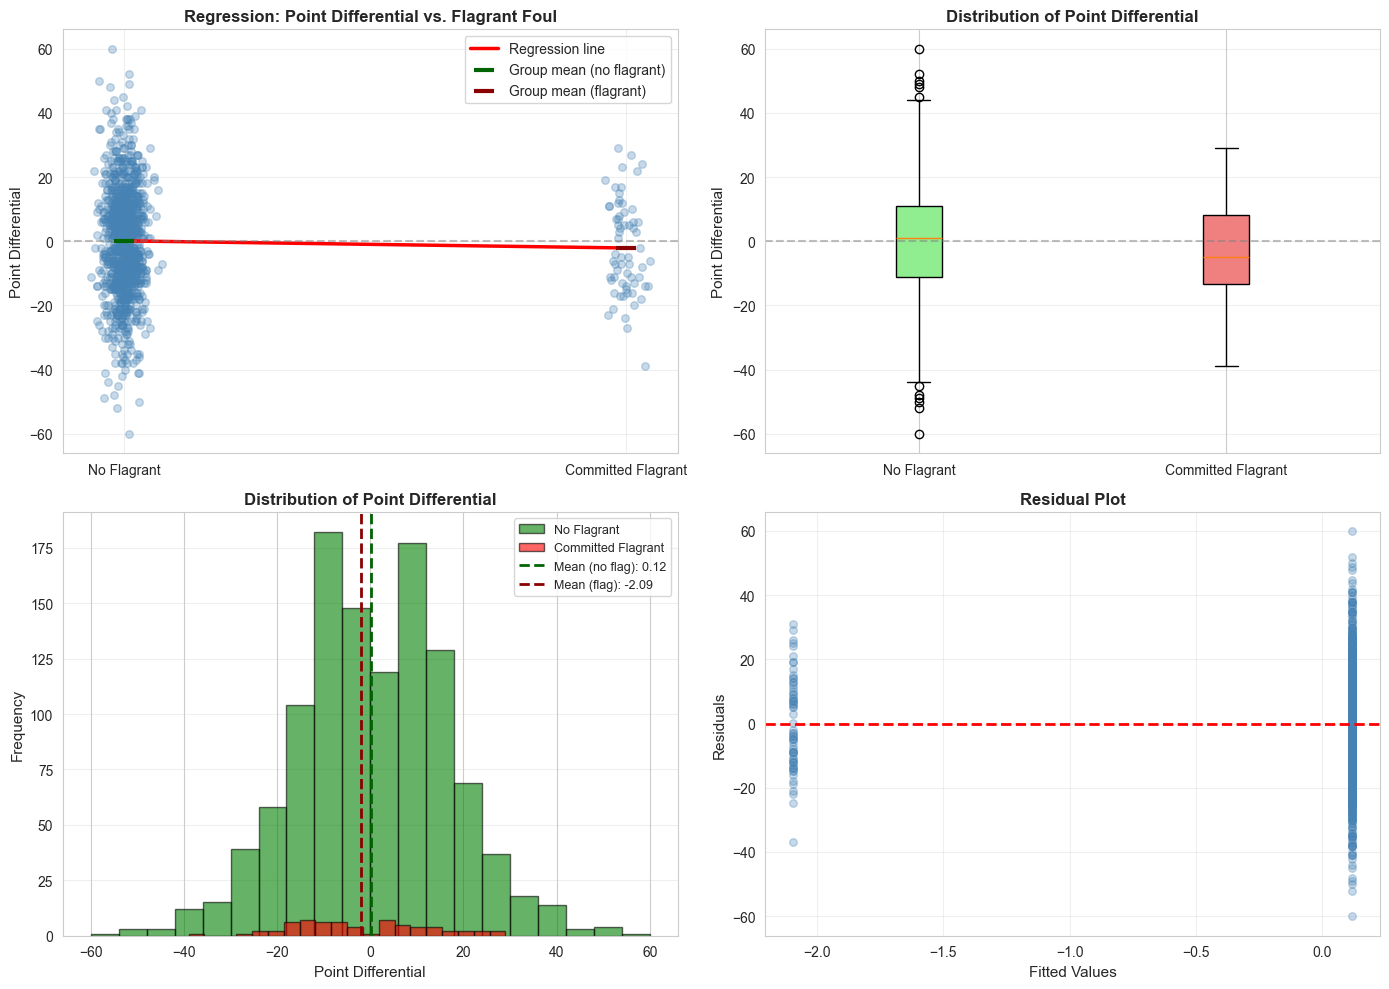

In [8]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot with regression line
ax1 = axes[0, 0]
x_jitter = df['committed_flagrant'] + np.random.normal(0, 0.02, len(df))
ax1.scatter(x_jitter, df['point_differential'], alpha=0.3, s=30, color='steelblue')

# Add regression line
x_line = np.array([0, 1])
y_line = intercept + flagrant_coef * x_line
ax1.plot(x_line, y_line, 'r-', linewidth=2.5, label=f'Regression line')

# Add group means
ax1.scatter([0], [mean_no_flagrant], color='darkgreen', s=200, marker='_', linewidth=3, label='Group mean (no flagrant)', zorder=5)
ax1.scatter([1], [mean_with_flagrant], color='darkred', s=200, marker='_', linewidth=3, label='Group mean (flagrant)', zorder=5)

ax1.set_xticks([0, 1])
ax1.set_xticklabels(['No Flagrant', 'Committed Flagrant'])
ax1.set_ylabel('Point Differential', fontsize=11)
ax1.set_title('Regression: Point Differential vs. Flagrant Foul', fontsize=12, fontweight='bold')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# 2. Box plot
ax2 = axes[0, 1]
data_for_box = [group1, group2]
bp = ax2.boxplot(data_for_box, labels=['No Flagrant', 'Committed Flagrant'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
ax2.set_ylabel('Point Differential', fontsize=11)
ax2.set_title('Distribution of Point Differential', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Histogram
ax3 = axes[1, 0]
ax3.hist(group1, bins=20, alpha=0.6, label='No Flagrant', color='green', edgecolor='black')
ax3.hist(group2, bins=20, alpha=0.6, label='Committed Flagrant', color='red', edgecolor='black')
ax3.axvline(mean_no_flagrant, color='darkgreen', linestyle='--', linewidth=2, label=f'Mean (no flag): {mean_no_flagrant:.2f}')
ax3.axvline(mean_with_flagrant, color='darkred', linestyle='--', linewidth=2, label=f'Mean (flag): {mean_with_flagrant:.2f}')
ax3.set_xlabel('Point Differential', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Distribution of Point Differential', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Residuals plot
ax4 = axes[1, 1]
predicted = model.fittedvalues
residuals = model.resid
ax4.scatter(predicted, residuals, alpha=0.3, s=30, color='steelblue')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Fitted Values', fontsize=11)
ax4.set_ylabel('Residuals', fontsize=11)
ax4.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('point_differential_analysis.png', dpi=300, bbox_inches='tight')
print("Plot saved as: point_differential_analysis.png")
plt.show()

## 7. Summary Table

In [9]:
# Clean summary table
summary_data = {
    'Variable': ['Committed Flagrant Foul'],
    'Coefficient': [f"{flagrant_coef:.4f}"],
    'Std. Error': [f"{flagrant_se:.4f}"],
    '95% CI': [f"[{flagrant_ci[0]:.4f}, {flagrant_ci[1]:.4f}]"],
    't-statistic': [f"{flagrant_coef/flagrant_se:.4f}"],
    'P-value': [f"{flagrant_pval:.4f}"],
    'Sig': ['*' if flagrant_pval < 0.05 else '']
}

summary_table = pd.DataFrame(summary_data)
print("\nSUMMARY TABLE:")
print(summary_table.to_string(index=False))
print("\nNote: * indicates p < 0.05")
print(f"\nModel: Point Differential = {intercept:.4f} + {flagrant_coef:.4f} * Committed_Flagrant")


SUMMARY TABLE:
               Variable Coefficient Std. Error            95% CI t-statistic P-value Sig
Committed Flagrant Foul     -2.2117     2.0925 [-6.3170, 1.8936]     -1.0570  0.2907    

Note: * indicates p < 0.05

Model: Point Differential = 0.1180 + -2.2117 * Committed_Flagrant
